Predict the age of abalone from physical measurements

Прежде всего, импортируем необходимые библиотеки и загрузим данные.
Переведем нечисловые значения пола в числовые.
Сформируем матрицы признаков и целевой переменной.

In [119]:
from ucimlrepo import fetch_ucirepo 

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
    


from sklearn.feature_selection import SelectKBest

from pandas import DataFrame
import seaborn as sns
import numpy as np

abalone = fetch_ucirepo(id=1) 

abalone.data.original.loc[abalone.data.original['Sex'] == 'M', abalone.data.original.columns == 'Sex'] = 1
abalone.data.original.loc[abalone.data.original['Sex'] == 'F', abalone.data.original.columns == 'Sex'] = 2
abalone.data.original.loc[abalone.data.original['Sex'] == 'I', abalone.data.original.columns == 'Sex'] = 3

data_abalone = abalone.data.original
features = abalone.data.features.columns

X = data_abalone.iloc[:, data_abalone.columns != 'Rings'].values
y = data_abalone.iloc[:, data_abalone.columns == 'Rings'].values.ravel()

Посмотрим на корреляцию между признаками и целевой переменной.
Таким образом можно определить наиболее значимые признаки.

In [120]:
new_X = SelectKBest(k = 5).fit(X, y).get_feature_names_out(input_features = features)
print(new_X)

data_abalone = data_abalone[['Length', 'Diameter', 'Height', 'Whole_weight', 'Shell_weight', 'Rings']]
X = data_abalone.iloc[:, data_abalone.columns != 'Rings'].values

['Length' 'Diameter' 'Height' 'Whole_weight' 'Shell_weight']


Теперь можно визуально оценить зависимости между выбранными признаками и целевой переменной.

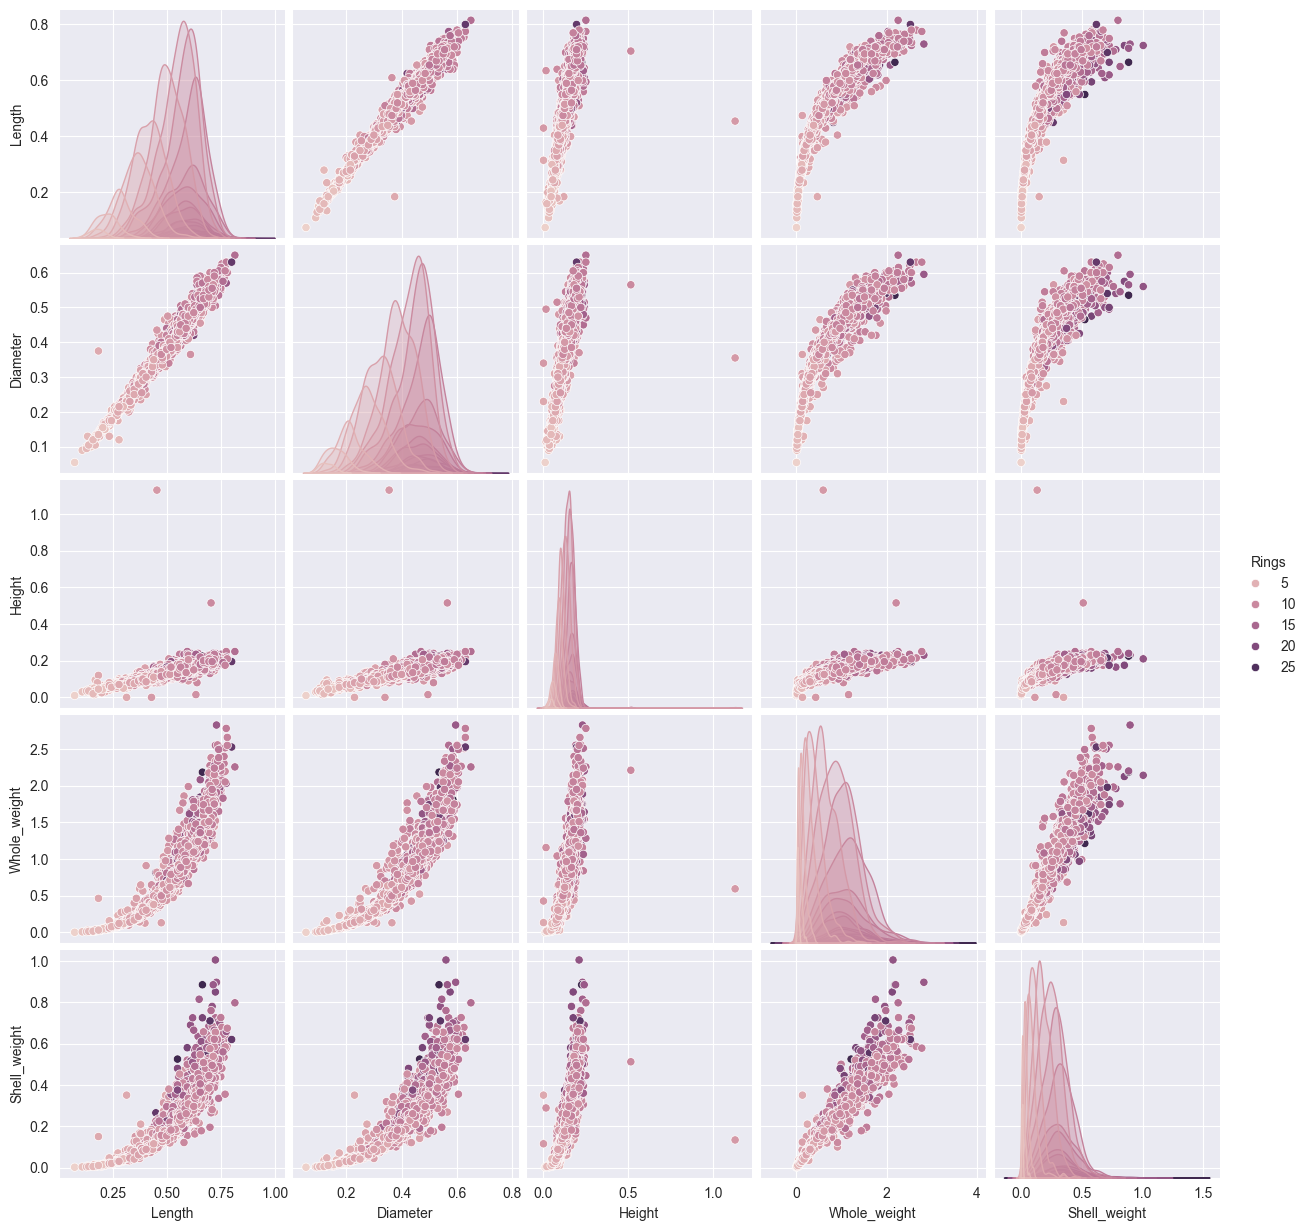

In [121]:
sns.pairplot(data=data_abalone, hue='Rings')

Можно заменить, что в датасете присутствуют выбросы, которые могут повлиять на точность моделей.
Для наглядности построим еще одну визуализацию.

<Axes: >

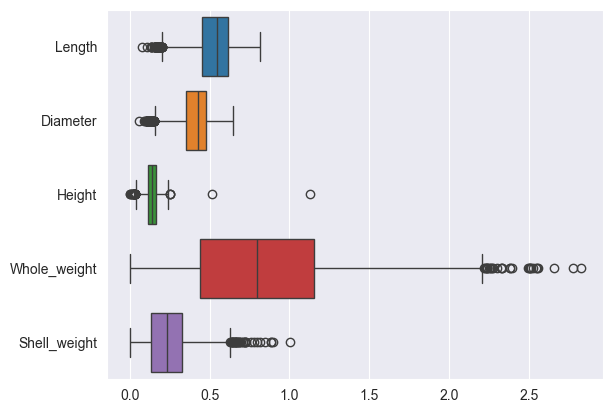

In [122]:
data_features = data_abalone[['Length', 'Diameter', 'Height', 'Whole_weight', 'Shell_weight']]
sns.boxplot(data=data_features, orient='h')

Теперь можно удалить выбросы и посмотреть на результат.

In [123]:
print(data_abalone.shape)

'''
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_samples': [50, 100, 256],
    'contamination': [0.01, 0.05, 0.1],
    'max_features': [1, 3, 5]
}

iso_forest = IsolationForest(random_state=42)

grid_search = GridSearchCV(iso_forest, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

print("Best:", grid_search.best_params_)
'''

print("Best: {'contamination': 0.01, 'max_features': 1, 'max_samples': 50, 'n_estimators': 100}")

(4177, 6)
Best: {'contamination': 0.01, 'max_features': 1, 'max_samples': 50, 'n_estimators': 100}


In [124]:
data = data_abalone[['Height']]

iso_forest = IsolationForest(
    n_estimators=100,
    max_samples=50,
    contamination=0.01,
    random_state=42)
outliers = iso_forest.fit_predict(data)

data_abalone = data_abalone[outliers != -1]
y = data_abalone.iloc[:, data_abalone.columns == 'Rings'].values.ravel()

print(data_abalone.shape)

(4144, 6)


Посмотрим на корреляцию между признаками и целевой переменной при удалении выбросов.

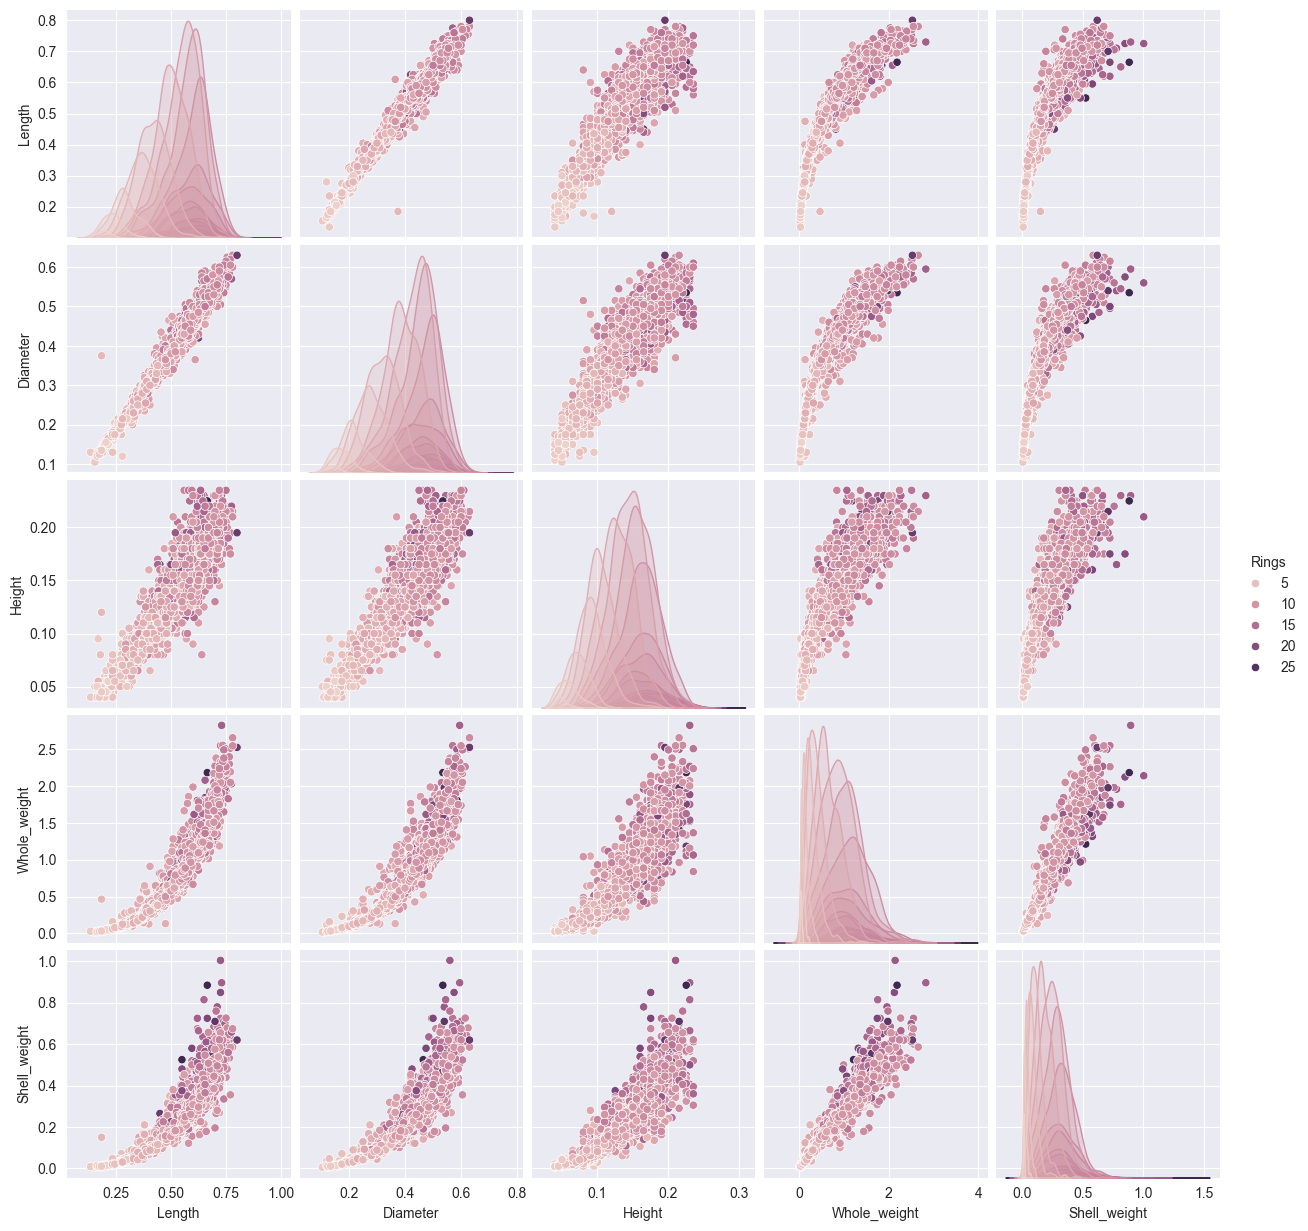

In [125]:
sns.pairplot(data=data_abalone, hue='Rings')

Теперь можно приступить к обучению моделей и оценке их точности.
Выберем модели и настроим их параметры.
Также разобьем данные на обучающую и тестовую выборки.

In [154]:
trg = data_abalone[['Rings']]
trn = data_abalone.drop(['Rings'], axis = 1)
y_train, y_test, X_train, X_test = train_test_split(trg, trn, test_size = 0.3, random_state = 42)

'''
KNN

param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]
}

model = KNeighborsRegressor()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f'Лучшие параметры: {grid_search.best_params_}')
'''

print("KNN - Лучшие параметры: {'algorithm': 'brute', 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}")

'''
RANDOM FOREST

param_grid = {
    'n_estimators': [100, 200, 300],            
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

model = RandomForestRegressor()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f'Лучшие параметры: {grid_search.best_params_}')
'''

print("RF - Лучшие параметры: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}")

'''
SVC
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'coef0': [0, 0.1, 0.5, 1]
}

model = SVC()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f'Лучшие параметры: {grid_search.best_params_}')
'''

print("SVC - Лучшие параметры: {'C': 100, 'coef0': 0, 'gamma': 'scale'}")

KNN - Лучшие параметры: {'algorithm': 'brute', 'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
RF - Лучшие параметры: {'bootstrap': True, 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
SVC - Лучшие параметры: {'C': 100, 'coef0': 0, 'gamma': 'scale'}


Теперь зная лучшие параметры, можно инициализировать модели.

In [155]:
models = [
    RandomForestRegressor(n_estimators=100, 
                          max_features ='log2',
                          min_samples_leaf = 4,
                          min_samples_split = 10,
                          max_depth = 10,
                          bootstrap = True,
                          random_state=42),
    LinearRegression(),
    KNeighborsRegressor(algorithm = 'brute',
                        n_neighbors = 15,
                        p = 1,
                        weights = 'distance'),
    make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    make_pipeline(PolynomialFeatures(degree=2), KNeighborsRegressor(algorithm = 'brute',
                                                                     n_neighbors = 15,
                                                                     p = 1,
                                                                     weights = 'distance')),
    make_pipeline(PolynomialFeatures(degree=2), RandomForestRegressor(n_estimators=100,
                                                                        max_features ='log2',
                                                                        min_samples_leaf = 4,
                                                                        min_samples_split = 10,
                                                                        max_depth = 10,
                                                                        bootstrap = True,
                                                                        random_state=42)),
    SVC(C=100, coef0=0, gamma='scale', degree = 3, random_state=42)
]

X_test = X_test.values
X_train = X_train.values
y_test = y_test.values.ravel()
y_train = y_train.values.ravel()

Теперь обучим модели и посмотрим на результаты коэффициента детерминации

In [156]:
training_models = {}
names = ['RFR', 'LR', 'KNN', 'LR_poly', 'KNN_poly', 'RFR_poly', 'SVC']
RMSE = []
R2 = []
MAE = []

for model in models:
    model.fit(X_train, y_train)
    RMSE.append(np.sqrt(mean_squared_error(y_test, model.predict(X_test))))
    R2.append(r2_score(y_test, model.predict(X_test)))
    MAE.append(mean_absolute_error(y_test, model.predict(X_test)))
    
training_models['RMSE'] = RMSE
training_models['R2'] = R2
training_models['MAE'] = MAE

ModelsResults = DataFrame(data=training_models, index=names, columns=['RMSE', 'R2', 'MAE'])
print(ModelsResults)

              RMSE        R2       MAE
RFR       2.282446  0.522422  1.614813
LR        2.359995  0.489418  1.700494
KNN       2.357853  0.490345  1.639655
LR_poly   2.260207  0.531683  1.613535
KNN_poly  2.358918  0.489884  1.650616
RFR_poly  2.269878  0.527667  1.606636
SVC       2.888329  0.235220  1.808682


Теперь визуализируем результаты и подведем итоги по выбору модели.

<Axes: >

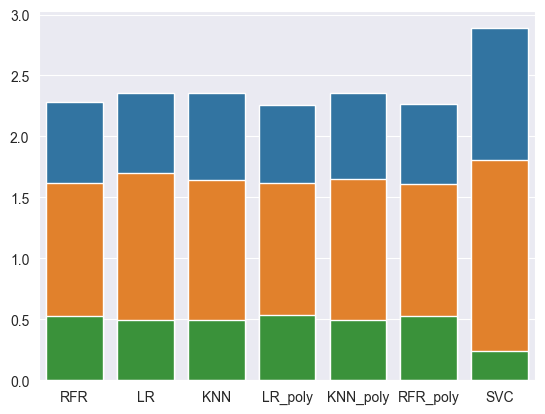

In [166]:
sns.barplot(x=names, y=RMSE)
sns.barplot(x=names, y=MAE)
sns.barplot(x=names, y=R2)

Исходя из результатов, можно сделать вывод, что наилучший результат показала модель RandomForestRegressor с полиномиальными признаками.
Таким образов она и будет являться наилучшей моделью для предсказания возраста моллюска Абалон.